In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data.metrics import get_metrics

In [84]:
df = pd.read_json("../reports/ablation_all.jsonl", lines=True, orient='records')
metrics = ['top_5_accuracy', 'top_1_accuracy']
get_metrics(df, metrics)
df['loc_level'] = df['loc_level'].fillna("all")

In [85]:
metrics = ['top_5_accuracy', 'top_1_accuracy']
dfp = df[df['model_cls'] == 'BiTULER']
dfm = dfp.groupby(['loc_level', 'dataset', 'model_cls'])[metrics].agg(['mean', 'std']).reset_index()

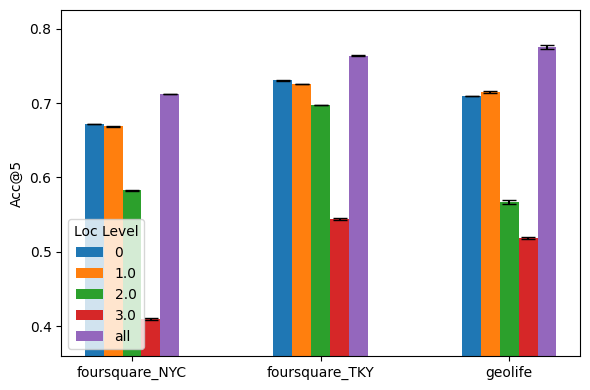

In [86]:
metric = "top_5_accuracy"
# Extract necessary data
datasets = dfm["dataset"].unique()
configs = [
    {
        "loc_level": level,
        "embedding_weight_factor": 2,
        "embedding_type": "lookup_weighted_concat",
    }
    for level in range(-1, -5, 1)
]
configs += [
    {
        "loc_level": "all",
        "embedding_weight_factor": factor,
        "embedding_type": "lookup_weighted_concat",
    }
    for factor in [1, 2]
]
configs += [
    {
        "loc_level": "all",
        "embedding_weight_factor": 2,
        "embedding_type": "lookup_concat",
    }
]
# TODO: use configs for filtering dataframe

loc_levels = dfm["loc_level"].unique()

# Create bar plot data
bar_width = 0.1
x = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(6, 4))

for i, config in enumerate(configs):
    subset = dfm[
        (dfm["loc_level"] == config["loc_level"])
        & (dfm["embedding_weight_factor"] == config["embedding_weight_factor"])
        & (dfm["embedding_type"] == config["embedding_type"])
    ]
    means = subset[metric]["mean"]
    stds = subset[metric]["std"]

    # Plot bars with error bars
    ax.bar(
        x + i * bar_width,
        means,
        bar_width,
        yerr=stds,
        label="TODO: fill label",
        capsize=5,
    )

# Customize the plot
pad = 0.05
ax.set_ylim([dfm[metric]["mean"].min() - pad, dfm[metric]["mean"].max() + pad])
ax.set_ylabel("Acc@5")
ax.set_xticks(x + (bar_width * (len(loc_levels) - 1) / 2))
ax.set_xticklabels(datasets)
ax.legend(title="Loc Level")

plt.tight_layout()

In [75]:
np.logspace(0, -3, 4, base=2)

array([1.   , 0.5  , 0.25 , 0.125])

In [76]:
[2 ** -i for i in [0, 1, 2 , 3]]

[1, 0.5, 0.25, 0.125]